## libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from tqdm import tqdm_notebook
import scipy.integrate as integrate

## file reading

In [2]:
in_file='NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18.6811_CMD_separated_singles.txt'

Numx, Numy, x_name,y_name, name= 21, 15, 'BP-RP, mag','G, mag','CMD_cutted'

# reading input file  and creating data-arrays
singles = pd.read_csv(in_file, delimiter=';', header=None)
singles.rename(columns = {Numx : x_name, Numy : y_name}, inplace=True)
singles = singles.apply(pd.to_numeric, errors='coerce')
singles.dropna(subset = ['G, mag','BP-RP, mag'], inplace = True)
is_giant = (singles['G, mag'] < 6.5)
giants_index = singles.index[is_giant]
singles.drop(giants_index, inplace=True)

## choosing the best degree

In [3]:
degrees = pd.DataFrame(data = {'degree': [], 'SD': [], 'delta_max':[]})
for degree in range(8,35):
    popt = np.polyfit(singles['G, mag'], singles['BP-RP, mag'],degree)
    func_iso = np.poly1d(popt)
    isochrone = pd.DataFrame(data = {'G, mag' : np.linspace(singles['G, mag'].min()-0.25, singles['G, mag'].max()+0.25, 500)})
    func_inter = interp1d( isochrone['G, mag'], func_iso(isochrone['G, mag']))
    singles[f'color_index_new_{degree}'] = func_inter(singles['G, mag']) - func_iso(singles['G, mag'])
    summa = singles[f'color_index_new_{degree}'][singles['G, mag']<18].pow(2).sum()
    distance = np.abs(singles[f'color_index_new_{degree}'][singles['G, mag']<18]).max()
    df = pd.DataFrame(data = {'degree': [degree], 'SD': [np.sqrt(summa)], 'delta_max':[distance]})
    degrees = degrees.append(df, ignore_index=True, sort=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packa

In [4]:
degrees[degrees['delta_max'] == degrees['delta_max'].min()]

,degree,SD,delta_max
22,30.0,0.000171,0.000018


## polynomial fit

set here a degree

In [5]:
degree = 30

In [6]:
popt = np.polyfit(singles['G, mag'], singles['BP-RP, mag'],degree)
func_iso = np.poly1d(popt)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


In [7]:
isochrone = pd.DataFrame(data = {'G, mag' : np.linspace(singles['G, mag'].min()-0.25, singles['G, mag'].max()+0.25, 500)})

## plot

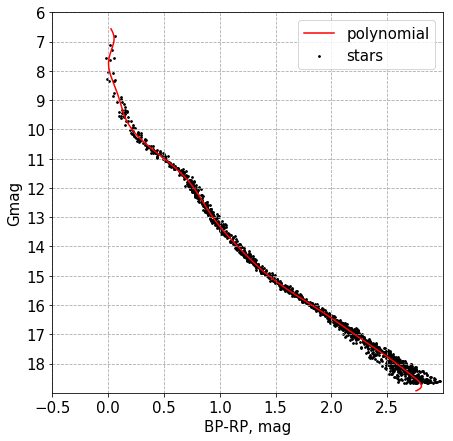

In [8]:
fig, ax = plt.subplots(figsize=(7,7 ))
ax.scatter (singles['BP-RP, mag'] , singles['G, mag'] , c ='black', s = 3, label ='stars')
ax.plot(func_iso(isochrone['G, mag']),isochrone['G, mag'] , c ='red', lw = 1.5, label ='polynomial') 
ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.arange(6, 19, step=1.0))
plt.xticks(np.arange(-0.5, 3, step=0.5))
ax.set_ylim(6, 19) 
ax.set_xlim(-0.5, 3)
ax.invert_yaxis()

plt.xlabel('BP-RP, mag', size = 15)
plt.ylabel('Gmag', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize = 15)

plt.show()

## coordinate system transformation

In [9]:
in_file = 'NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18.6811.txt'

all_stars = pd.read_csv(in_file, delimiter=';', header=None)
all_stars.rename(columns = {Numx : x_name, Numy : y_name}, inplace=True)
all_stars = all_stars.apply(pd.to_numeric, errors='coerce')
all_stars.dropna(subset = ['G, mag','BP-RP, mag'], inplace = True)
is_giant = (all_stars['G, mag'] < 6.5)
giants_index = all_stars.index[is_giant]
all_stars.drop(giants_index, inplace=True)

In [10]:
func_inter = interp1d(isochrone['G, mag'], func_iso(isochrone['G, mag']))
all_stars['color_index_new'] =  all_stars['BP-RP, mag']- func_inter(all_stars['G, mag'])

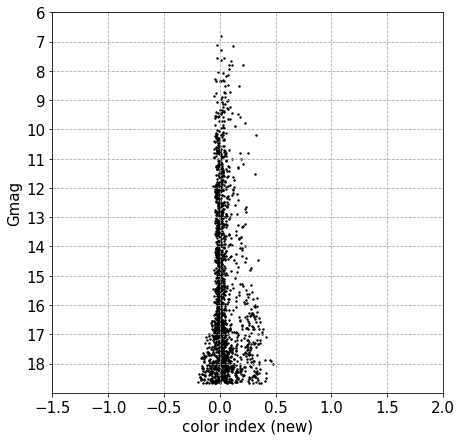

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(all_stars['color_index_new'],all_stars['G, mag'], c ='black',s=2)

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.arange(6, 19, step=1.0))
ax.set_ylim(6, 19) 
ax.set_xlim(-1.5, 2)
ax.invert_yaxis()

plt.xlabel('color index (new)', size = 15)
plt.ylabel('Gmag', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("main_sequence_vertical.png", dpi = 200)

## splitting in intervals of equal size

In [12]:
group_size = 113
all_stars.sort_values(by = 'G, mag', inplace=True)
num_groups = int(len(all_stars)/group_size) 

if num_groups * group_size < len(all_stars):
    num_groups += 1

In [13]:
group_labels = np.arange(num_groups)
group_labels = np.repeat(group_labels, group_size)
group_labels = group_labels[0:len(all_stars)]

all_stars['label'] = group_labels

In [14]:
dictionary = {}
for i in all_stars['label'].unique():
    mask = (all_stars['label'] == i)
    dictionary[i]= pd.Interval(all_stars['G, mag'][mask].min(), all_stars['G, mag'][mask].max(), closed='both')

In [15]:
profile = pd.DataFrame(data = {'x' : np.linspace(-1, 1, 701)})
for label in all_stars['label'].to_numpy():
    bin_stars = all_stars[all_stars['label'] == label]
    num_stars = len(bin_stars)
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.07)
    kde.fit(bin_stars[['color_index_new']].to_numpy())
    
    profile[f'{dictionary[label]}'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
    profile[f'{dictionary[label]}'] *= num_stars

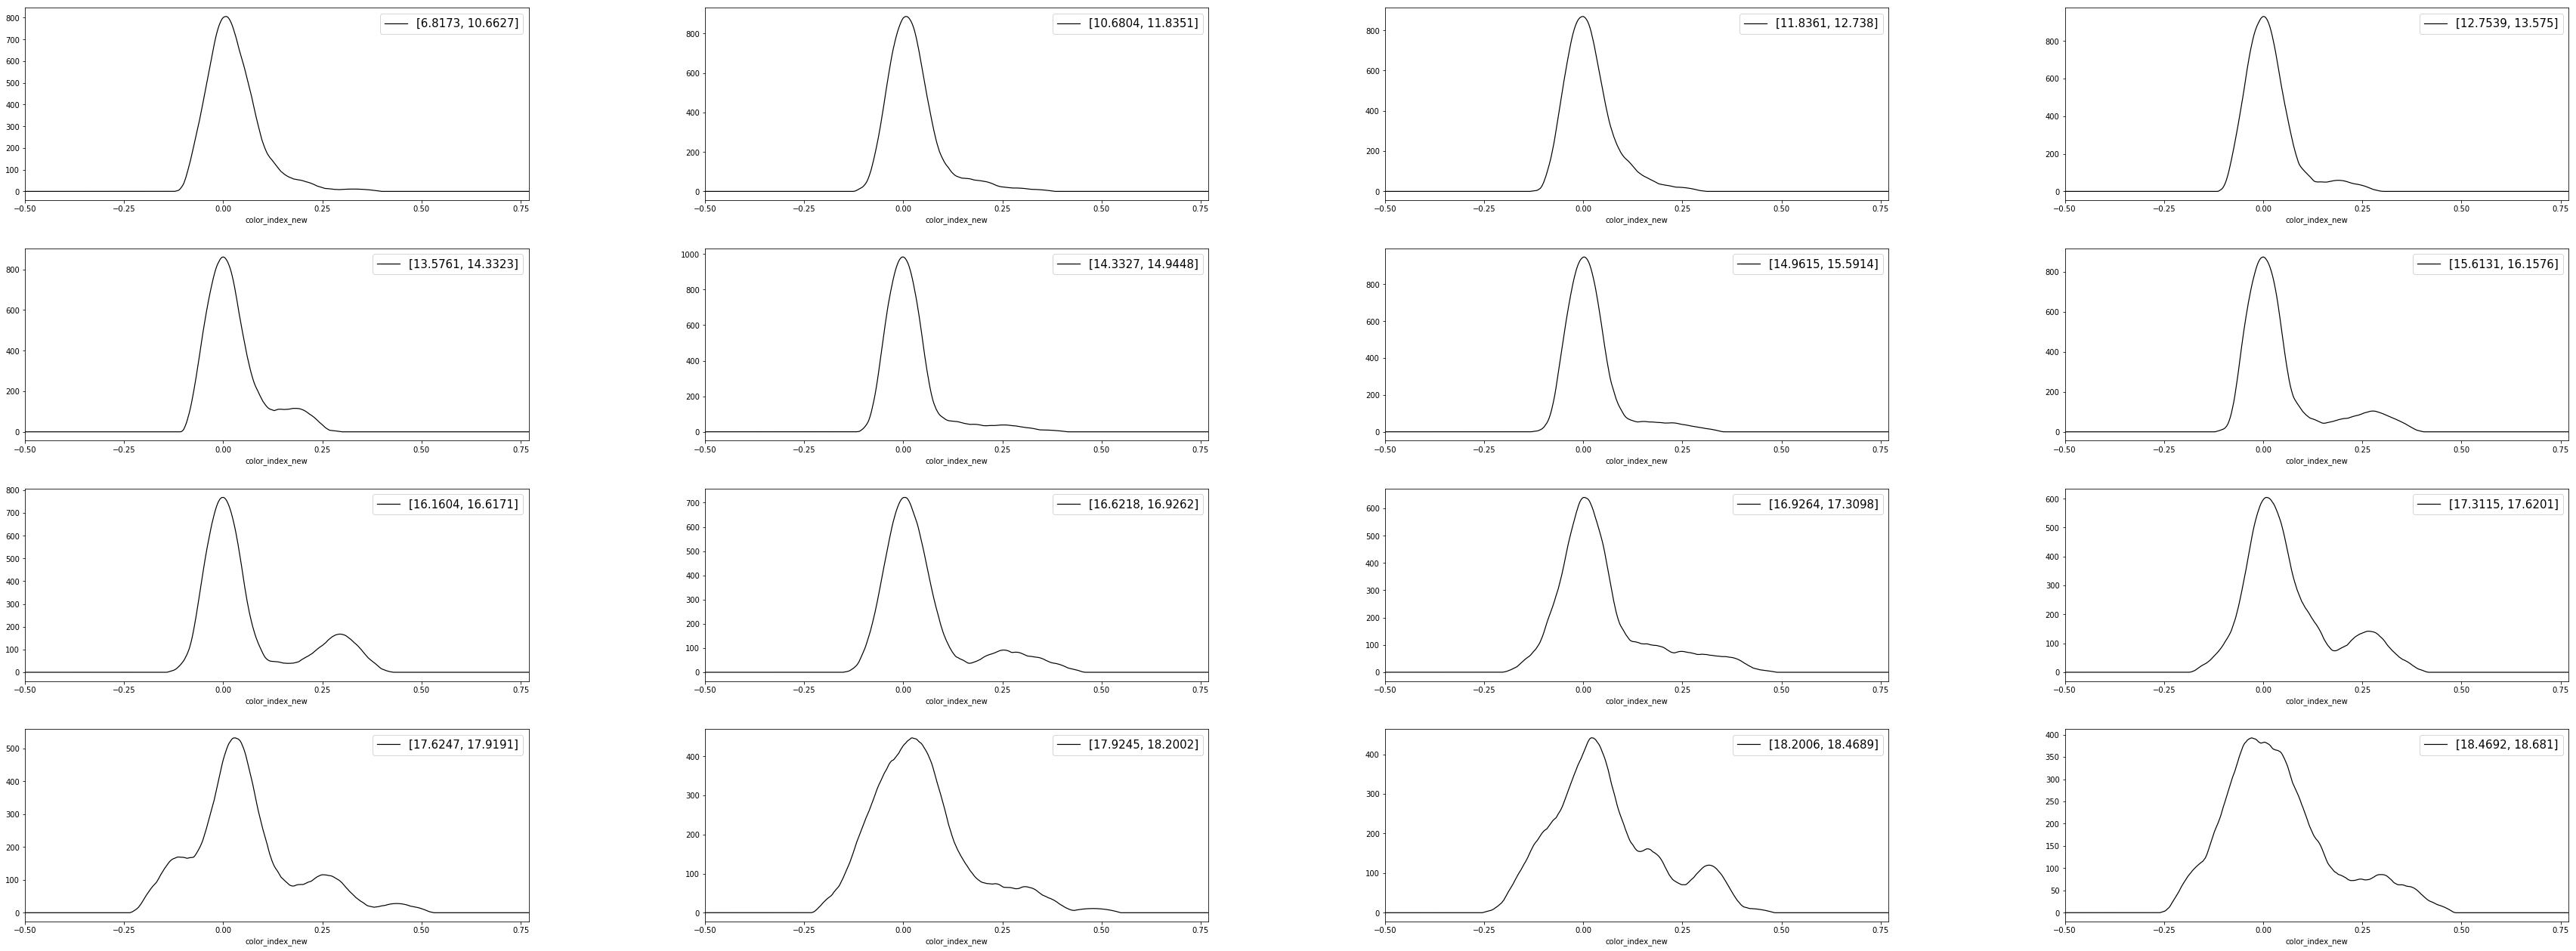

In [16]:
plt.figure(figsize=(55,20))
for i in range(1, num_groups+1):
    plt.subplot(4, 4, i)
    plt.plot(profile['x'], profile.iloc[:,i], lw = 1.2, color = 'black')
    plt.xticks(np.arange(-0.5, 0.77, step=0.25))
    plt.xlim(-0.5, 0.77)
    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel('color_index_new', size = 10)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)


## approximation for singles 

In [17]:
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2 / c)

# i is bin number
bin_popts = []
for i in tqdm_notebook(range(1,num_groups+1)):
    row_max = profile.iloc[:, i].idxmax()
    popt, pcov = curve_fit(f, profile.iloc[row_max-25:row_max+15, 0], profile.iloc[row_max-25:row_max+15, i],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0],
                                   [1100, profile.iloc[row_max, 0]+0.1, 0.1]),
                          maxfev=5000)
    bin_popts.append(popt)

In [18]:
bin_names = profile.columns[1:].tolist()
profile_gauss = pd.DataFrame(data={'x': profile['x']},
                             columns=['x'] + bin_names)

for bin_name, bin_popt in zip(bin_names, bin_popts):
    profile_gauss[bin_name] = f(profile_gauss['x'], *bin_popt)

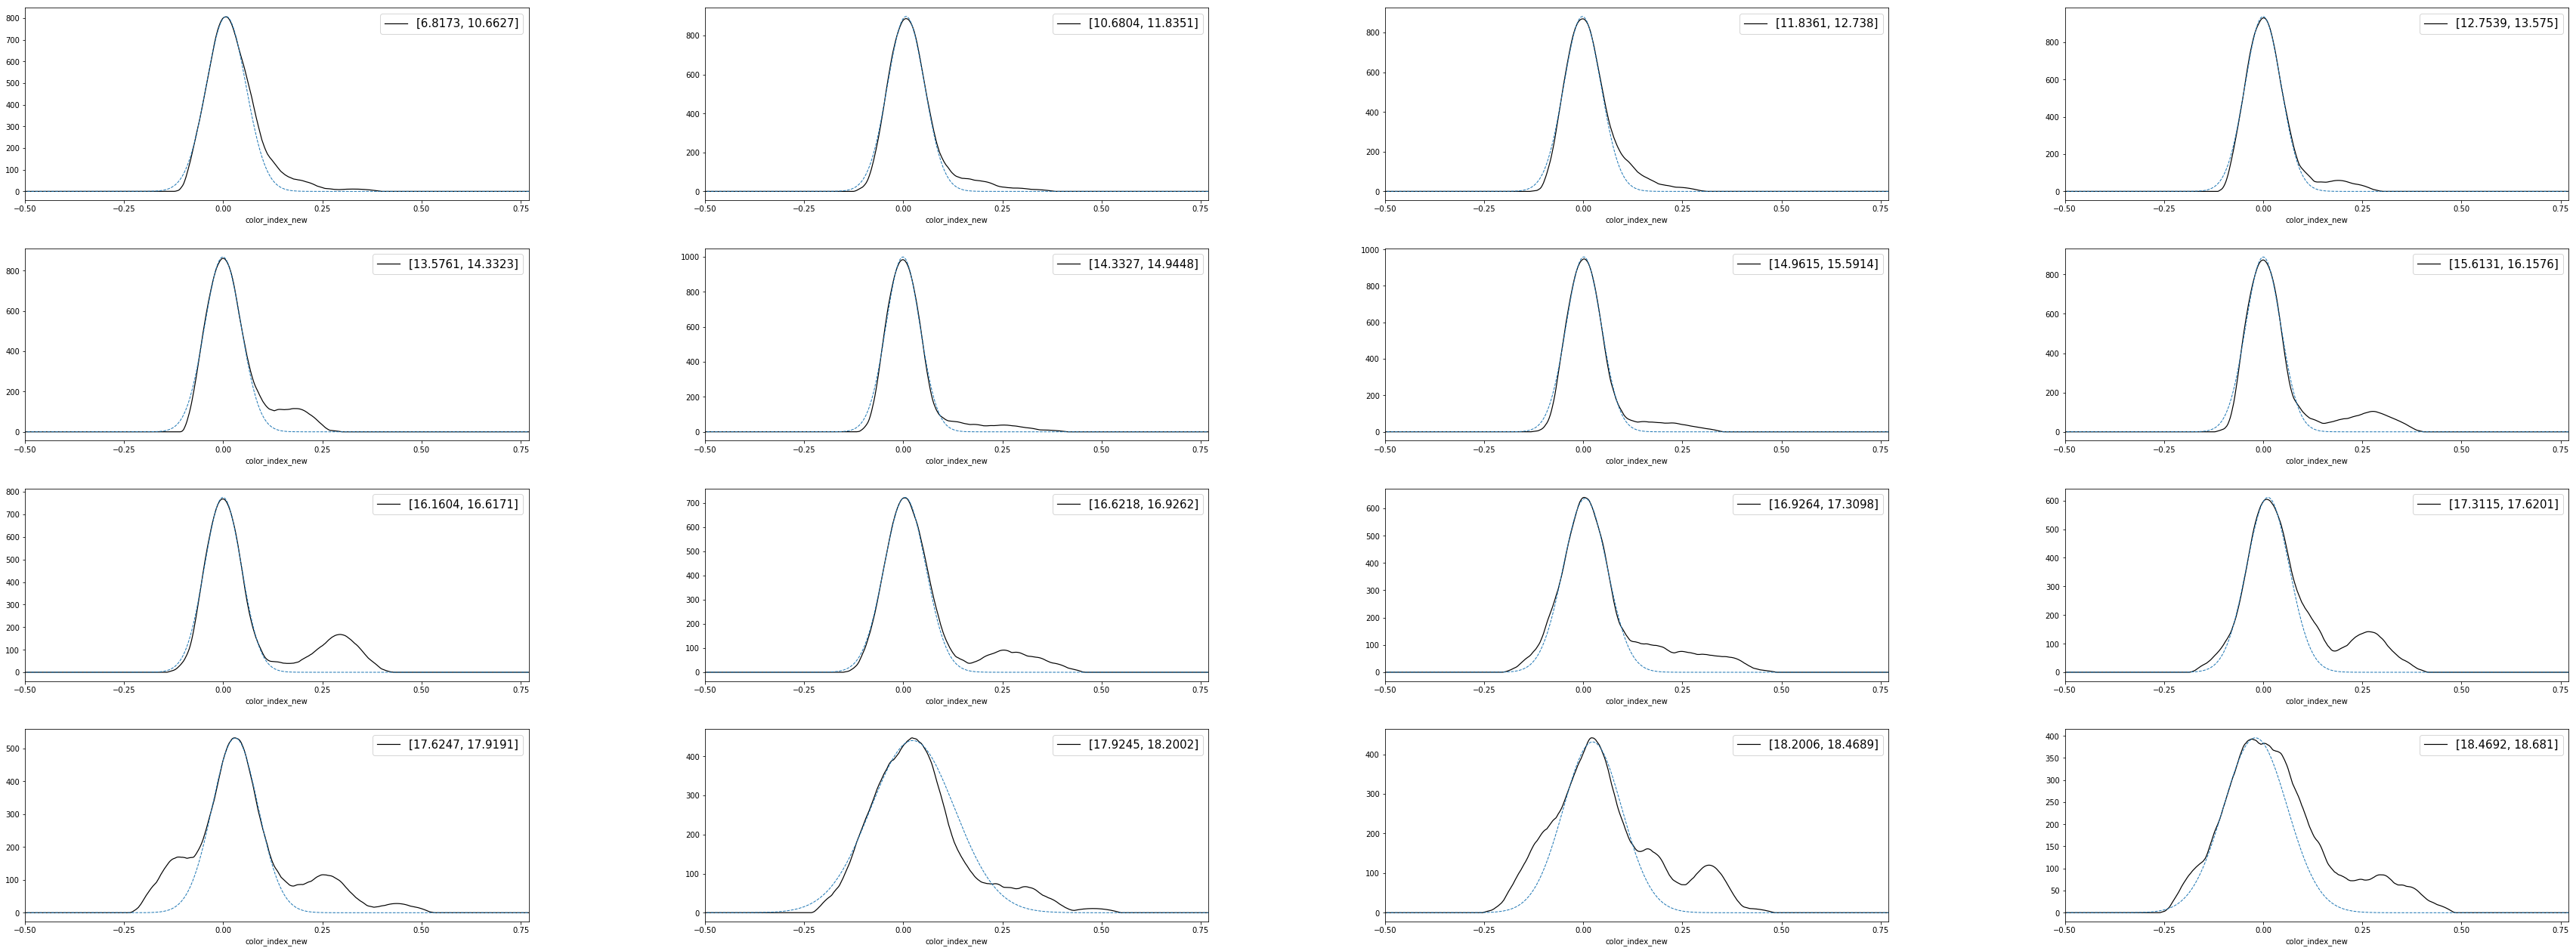

In [19]:
plt.figure(figsize=(55,20))
for i in range(1, num_groups+1):
    plt.subplot(4, 4, i)
    plt.plot(profile['x'], profile.iloc[:,i], lw = 1.2, color = 'black')
    plt.plot(profile_gauss['x'], profile_gauss.iloc[:,i], lw = 1, ls='--', label='_nolabel')
    plt.plot
    plt.xticks(np.arange(-0.5, 0.77, step=0.25))
    plt.xlim(-0.5, 0.77)
    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel('color_index_new', size = 10)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
plt.savefig('profiles_n113.png', dpi=200)

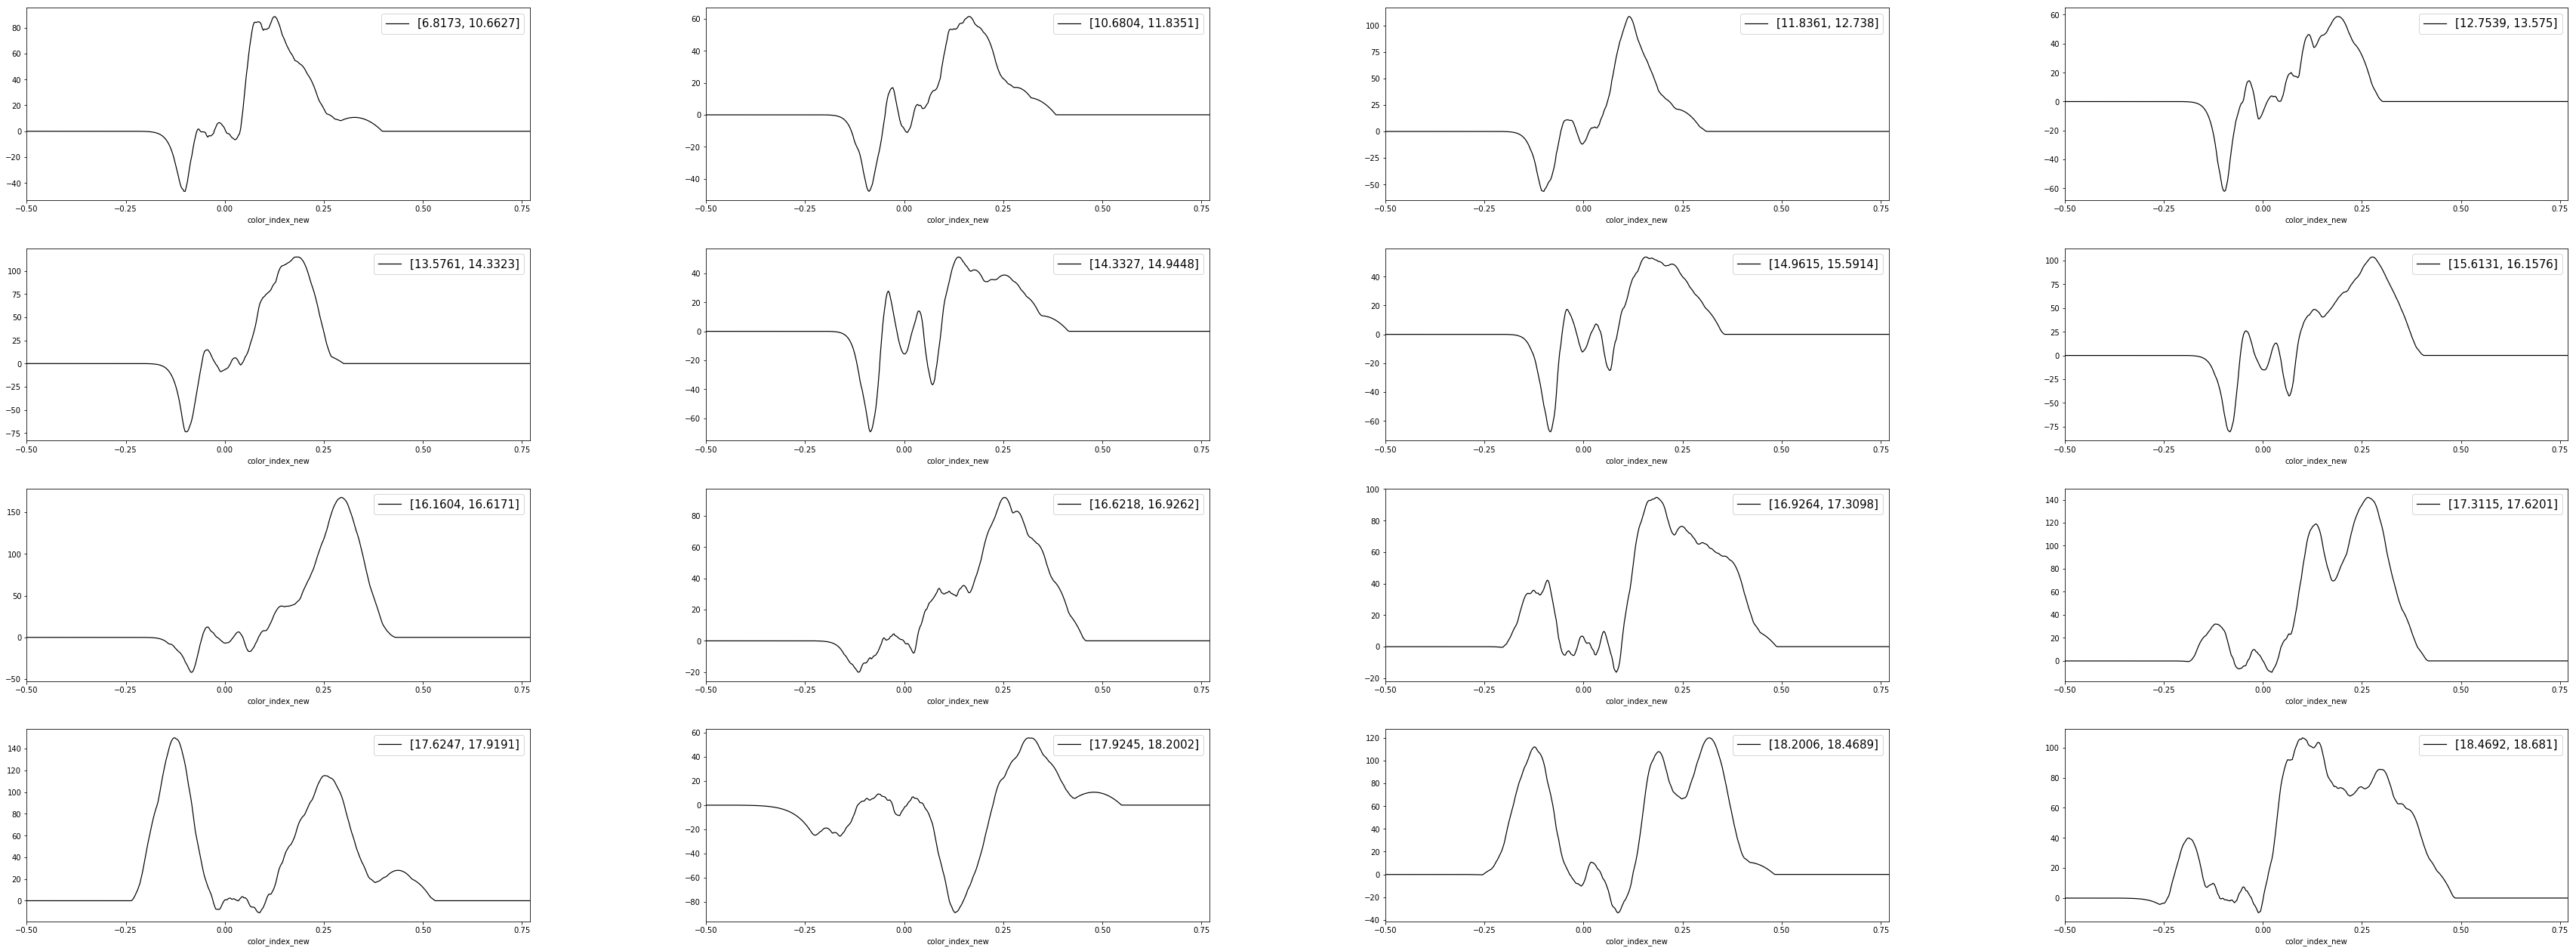

In [21]:
plt.figure(figsize=(55,20))
for i in range(1, num_groups+1):
    plt.subplot(4, 4, i)
    plt.plot(profile['x'], profile.iloc[:,i] - profile_gauss.iloc[:,i], lw = 1.2, color = 'black')
    plt.xticks(np.arange(-0.5, 0.77, step=0.25))
    plt.xlim(-0.5, 0.77)
    plt.legend(loc='upper right', fontsize=15)
    plt.xlabel('color_index_new', size = 10)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
plt.savefig('profile_difference_n113.png', dpi=200)

## star counts

In [22]:
bins = list(dictionary.values())
counts = pd.DataFrame(data = {'interval' : bins, 'G_mids': bins, 'all_stars' : bins, 'multiples' : bins})
for i in range(1, num_groups+1):
    counts['all_stars'].iloc[i-1] =  len(all_stars[all_stars['label'] == i-1])
    counts['G_mids'].iloc[i-1] = counts['interval'][i-1].mid
    
    row_max = profile.iloc[:, 1].idxmax()
    difference = profile.iloc[:,i] - profile_gauss.iloc[:,i]
    difference[difference < 0] = 0
    
    counts['multiples'].iloc[i-1] = int(integrate.trapz(difference.iloc[row_max:], profile['x'][row_max:]))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
counts['singles'] = counts['all_stars'] - counts['multiples']
counts['fraction'] = counts['multiples'] / counts['singles']

## binaries fraction plot

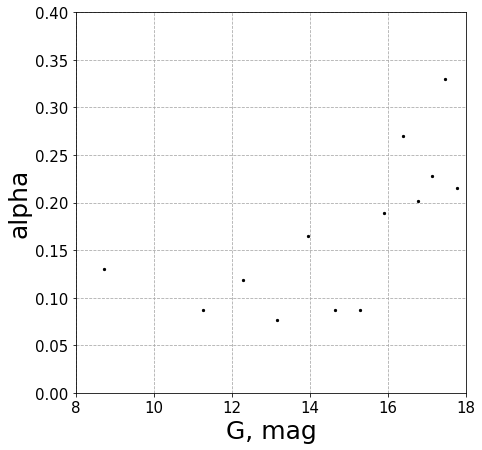

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(counts['G_mids'][counts['G_mids']<18], counts['fraction'][counts['G_mids']<18], c ='black',s=5)

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.set_ylim(0, 0.4) 
ax.set_xlim(8, 18)
plt.xlabel("G, mag", size = 25)
plt.ylabel("alpha", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("alpha.png", dpi = 200)

In [27]:
def f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

popt, pcov = curve_fit(f, counts['G_mids'], counts['fraction'])
popt2, pcov2 = curve_fit(f, counts['G_mids'][counts['G_mids']<18], counts['fraction'][counts['G_mids']<18])
err2 = np.sqrt(np.diag(pcov2))

array([ 8.23111513e-05,  1.83883990e-03, -7.75681868e-02,  6.14482342e-01])

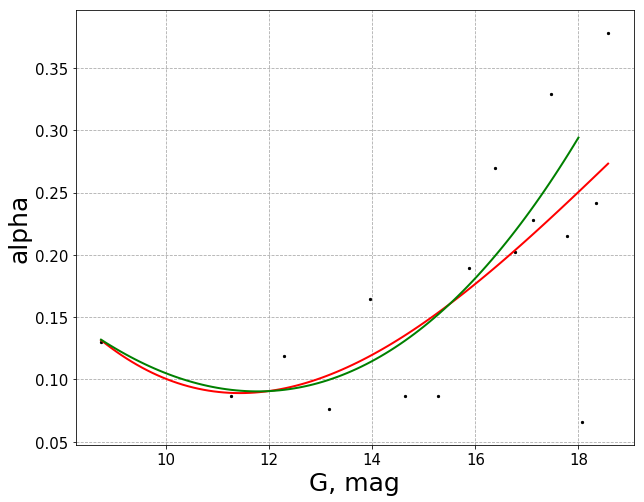

In [33]:
fig, ax = plt.subplots(figsize=(10,8 )) #16:14
ax.scatter(counts['G_mids'], counts['fraction'], c ='black',s=5)
ax.plot(np.linspace(counts['G_mids'].min(), counts['G_mids'].max(), num = 100), 
        f(np.linspace(counts['G_mids'].min(), counts['G_mids'].max(), num = 100), *popt),
        c = 'red', lw = 2)
ax.plot(np.linspace(counts['G_mids'].min(), 18, num = 100), 
        f(np.linspace(counts['G_mids'].min(), 18, num = 100), *popt2), 
        c = 'green', lw = 2)
#ax.plot(np.linspace(counts['G_mids'].min(), 18, num = 100), 
#        f(np.linspace(counts['G_mids'].min(), 18, num = 100), *(popt2+err2)), 
#        c = 'green', lw = 2)

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
plt.xlabel("G, mag", size = 25)
plt.ylabel("alpha", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig("alpha_dist.png", dpi = 200)

In [52]:
counts

,interval,G_mids,all_stars,binaries,singles,fraction
0,"[6.8173, 10.6627]",8.74,113,13,100,0.130000
1,"[10.6804, 11.8351]",11.2578,113,9,104,0.086538
2,"[11.8361, 12.738]",12.2871,113,12,101,0.118812
3,"[12.7539, 13.575]",13.1644,113,8,105,0.076190
4,"[13.5761, 14.3323]",13.9542,113,16,97,0.164948
5,"[14.3327, 14.9448]",14.6388,113,9,104,0.086538
6,"[14.9615, 15.5914]",15.2765,113,9,104,0.086538
7,"[15.6131, 16.1576]",15.8853,113,18,95,0.189474
8,"[16.1604, 16.6171]",16.3888,113,24,89,0.269663
9,"[16.6218, 16.9262]",16.774,113,19,94,0.202128


In [ ]:
# set multiples as binaries and compare models
# https://micropore.wordpress.com/2017/02/04/python-fit-with-error-on-y-axis/